<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Kernel setup

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%%capture
!git clone https://github.com/Krankile/npmf.git

In [34]:
%%capture
!cd npmf && git pull

In [35]:
%%capture
!pip install wandb

In [36]:
!wandb login

wandb: Currently logged in as: kjartan (krankile). Use `wandb login --relogin` to force relogin


##General setup

In [37]:
import os
import multiprocessing

from collections import defaultdict
from collections import Counter
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3
from npmf.utils.eikon import column_mapping
from npmf.utils.wandb import get_dataset, put_dataset, get_datasets, get_nn_model
from npmf.utils.training import EarlyStop, to_device, TqdmPostFix, mape_loss
from npmf.utils.dataset import EraDataset
from npmf.utils.dtypes import fundamental_types
from npmf.utils.training import mape_loss_2


In [38]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [40]:
device = "cpu"

In [41]:
np.random.seed(420)

# Set up a permutation loop to find what feature a net is utilizing 


In [42]:
#load model from cloud and get logged date, then create dataloader with fixed batchsize of this date 
# (batches, date, features)

## Create a dataloader and get load a neural network

In [43]:
%%capture
reload_data = False

if reload_data or not "stock_df" in vars():
    names = ["stock-data:final", "fundamental-data:final", "meta-data:final", "macro-data:final"]

    stock_df, fundamental_df, meta_df, macro_df = get_datasets(names=names, project="master")

    fundamental_df = fundamental_df.drop(columns="period_end_date").astype(fundamental_types)


In [44]:
model, conf = get_nn_model("TcnV1:v8", project="master") #TODO: conf should be updated with next model >v4 

In [45]:
era_dataset = EraDataset(current_time=pd.to_datetime("2002-01-01"), stock_df=stock_df, fundamental_df=fundamental_df, meta_df=meta_df, training_window=conf["training_w"], target_window=conf["forecast_w"], macro_df=macro_df, **conf)

In [46]:
era_dataloader = DataLoader(era_dataset, batch_size=len(era_dataset), shuffle=False, num_workers=multiprocessing.cpu_count())

## Plotting function

In [53]:
def plot_feature_importance(
    importances,
    *,
    savepath=None,
    useerror=None,
    show=True,
    normalize=False,
    figheight=12,
    figwidth=None,
    yticksize=10,
    cols=None,
):
    mean_results = {k: np.mean(v) for k, v in importances.items()}
    lab, vals = zip(*sorted(mean_results.items(), key=lambda x: x[1], reverse=True))
    vals = np.array(vals)

    if normalize:
        vals /= vals.sum()

    error = None
    if useerror is not None:
        if useerror == "sd":
            err = {k: np.std(importances[k]) for k in lab}
        elif useerror == "se":
            err = {
                k: np.std(importances[k]) / np.sqrt(len(importances[k])) for k in lab
            }

        error = [v for k, v in err.items()]

    plt.figure(figsize=(6,4))

    zero = np.zeros(len(lab))
    plt.barh(lab, zero, color=main)

    if cols:
        plt.barh(
            y=lab, width=vals, alpha=1, color=main, xerr=err.values(), label="Clusters"
        )
    else:
        plt.barh(
            lab, 
            vals,
            alpha=1,
            color=main,
            xerr=error,
            label="Model inputs",
        )

    plt.xlabel("Mape loss relative to baseline", fontsize=14)

    plt.legend(loc="upper right", frameon=False)
    if savepath is not None:
        plt.savefig(savepath)

    if show:
        plt.show()

## Define a permutation function

In [48]:
def baseline_permutation_loss(model, data_loader, name_to_slice, time_windows, n_permutations, conf):
      
    for data, meta_cont, meta_cat, target in to_device(data_loader, device):
            
        org_np = data.detach().numpy()
        with torch.no_grad():
            y_pred: torch.Tensor = model(data, meta_cont, meta_cat) #Do we need optimizer.zero_grad() here? 
            baseline = mape_loss(target, y_pred)
        permutation_losses = {}
        for (start, end) in tqdm(time_windows):
            for features_name, features_slice in tqdm(name_to_slice.items(), leave=False):
                permuted_org_np = org_np.copy()
                sub_np = org_np[:,start:end, features_slice]
                
                n_permutation_losses = []
                
                ypred_tensor_save = []
                for permuation in range(n_permutations):
                    sub_np_copy = sub_np.copy()
                    np.random.shuffle(sub_np_copy)
                    permuted_org_np[:,start:end, features_slice] = sub_np_copy
                    with torch.no_grad():
                        y_pred_sub = model(torch.Tensor(permuted_org_np), meta_cont, meta_cat)
                        ypred_tensor_save.append(y_pred_sub)
                        loss = mape_loss_2(target, y_pred_sub)
                        
                        n_permutation_losses.append(loss.item() - baseline.item())
                permutation_losses[f"{features_name}:({start}:{end})"] = n_permutation_losses
            

    return permutation_losses, baseline, ypred_tensor_save

## Get basline and deviation for interesting features and times

In [49]:
name_to_slice = dict(
    market_cap=slice(0,0),
    income_and_cashflow=slice(1,10),
    balance=slice(10,19),
)

Define the input :) 

In [50]:
era_dataset.data_fields
fields_to_scramble = pd.Series(era_dataset.data_fields)
time_windows = [(0,240)] #[(0,60), (60,120), (120,180), (180,240)]

## Now plot the losses

In [55]:
permutation_losses_8, baseline_8  , y_pred_lst_8 = baseline_permutation_loss(model, era_dataloader, name_to_slice=name_to_slice, time_windows=time_windows, n_permutations=50, conf=conf) #constant

if False:
    permutation_losses_3, baseline_3, y_pred_lst_3 = baseline_permutation_loss(model, era_dataloader, name_to_slice=name_to_slice, time_windows=time_windows, n_permutations=20, conf=conf) #constant
    permutation_losses, baseline, y_pred_lst = baseline_permutation_loss(model, era_dataloader, fields_to_scramble=fields_to_scramble, time_windows=time_windows, n_permutations=5, conf=conf) #constant 
    permutation_losses_1, baseline_1, y_pred_lst_1 = baseline_permutation_loss(model, era_dataloader, name_to_slice=name_to_slice, time_windows=time_windows, n_permutations=20, conf=conf) #not constant(but non-logical dependecy on signal)
    permutation_losses_4, baseline_4, y_pred_lst_4 = baseline_permutation_loss(model, era_dataloader, name_to_slice=name_to_slice, time_windows=time_windows, n_permutations=20, conf=conf) #constant


100%|██████████| 1/1 [07:02<00:00, 422.09s/it]


## Make some visualisations


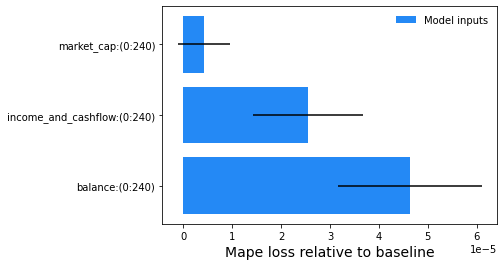

In [56]:
plot_feature_importance(permutation_losses_8, useerror="se")

In [ ]:
y_pred_lst_3

## Some parameter experimentation

In [22]:
def get_amount_of_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [23]:
tcn_params = get_amount_of_params(model.tcn)
params = get_amount_of_params(model)

0.8947055831209334

## Save runs

In [41]:
import pickle
def to_pickle(data,filename):
    with open(f'{filename}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
def load_pickle(filename):
    with open(f'{filename}.pickle', 'rb') as handle:
        return pickle.load(handle) 

In [74]:
permutation_losses_1 = load_pickle("permutation_losses_v1")

## Test sheesh! 😪

In [ ]:
arr = np.array([[11,12,13],
                [21,22,23]])
arr_2 = arr.reshape(3,2)
print(arr_2)
np.random.shuffle(arr_2)
print(arr_2.shape)
arr_2


[[11 12]
 [13 21]
 [22 23]]
(3, 2)


array([[11, 12],
       [13, 21],
       [22, 23]])

In [ ]:
arr = np.array([[[1, 2, 3], [3, 4, 5]], [[6,7,8], [9, 10, 11]]])
arr_test = arr[:, :60, 2]

In [ ]:
start, end = 0, 2
feature_i = 3
n_premutations = 1 

sub_np = arr[:,start:end, feature_i]
n_permutation_losses = []
for permuation in range(n_premutations):
    sub_np_copy = sub_np.copy()
    np.random.shuffle(sub_np_copy)

    permuted_org_np = arr.copy()
    permuted_org_np[:,start:end, feature_i] = sub_np_copy

In [ ]:
np.random.shuffle(arr_test)
arr_test

array([[ 8, 11],
       [ 3,  5]])

In [ ]:
arr

array([[[ 1,  2,  3],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [ ]:
arr_test

array([3, 8])

In [ ]:
np.ones((3,4,3)).cumsum().reshape(3,4,3)

array([[[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]],

       [[13., 14., 15.],
        [16., 17., 18.],
        [19., 20., 21.],
        [22., 23., 24.]],

       [[25., 26., 27.],
        [28., 29., 30.],
        [31., 32., 33.],
        [34., 35., 36.]]])

In [ ]:
arr = np.arange(27).reshape(3,3,3)
arr

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

In [ ]:
np.meshgrid(np.ones((5)).cumsum(),np.ones((240)).cumsum(), np.ones((10)).cumsum())

[array([[[1., 1., 1., ..., 1., 1., 1.],
         [2., 2., 2., ..., 2., 2., 2.],
         [3., 3., 3., ..., 3., 3., 3.],
         [4., 4., 4., ..., 4., 4., 4.],
         [5., 5., 5., ..., 5., 5., 5.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [2., 2., 2., ..., 2., 2., 2.],
         [3., 3., 3., ..., 3., 3., 3.],
         [4., 4., 4., ..., 4., 4., 4.],
         [5., 5., 5., ..., 5., 5., 5.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [2., 2., 2., ..., 2., 2., 2.],
         [3., 3., 3., ..., 3., 3., 3.],
         [4., 4., 4., ..., 4., 4., 4.],
         [5., 5., 5., ..., 5., 5., 5.]],
 
        ...,
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [2., 2., 2., ..., 2., 2., 2.],
         [3., 3., 3., ..., 3., 3., 3.],
         [4., 4., 4., ..., 4., 4., 4.],
         [5., 5., 5., ..., 5., 5., 5.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [2., 2., 2., ..., 2., 2., 2.],
         [3., 3., 3., ..., 3., 3., 3.],
         [4., 4., 4., ..., 4., 4., 4.],
         [5.,

In [ ]:
dim_1, dim_2, dim_3 = 3, 240, 5
a = np.ones(dim_1).cumsum()
b = np.ones(dim_2).cumsum()
c = np.ones(dim_3).cumsum()

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

arr = cartesian_product(a, b, c).reshape(3, 240, 5, 3)

## Delete below once we have moved timedeltadataset to eradataset

In [ ]:
def baseline_permutation_loss_fcnn(model, data_loader, dates_per_permutation, n_permuatations, conf):
      
    for (batches, date, features), meta_cont, meta_cat, target in to_device(data_loader, device):
        org_tensor = (batches, date, features)    
        org_np = org_tensor.detach().to_numpy()
        
        y_pred: torch.Tensor = model(org_tensor, meta_cont, meta_cat) #Do we need optimizer.zero_grad() here? 

        baseline = mape_loss(target, y_pred)
        permutation_losses = {}
        
        permutation_loss_dict = {}
        lst_of_features = ["test, "] #INSERT Feature ORDER HERE
        for (start, end) in tqdm([(0,60), (60,120), (120,180), (180,240)]):
            for feature_i, feature in enumerate(lst_of_features):
                sub_np = org_np[:,start:end, feature_i]
                n_permutation_losses = []
                for permuation in range(n_permuatations):
                    sub_np_copy = sub_np.copy()
                    np.random.shuffle(sub_np_copy)

                    permuted_org_np = org_np.copy()
                    permuted_org_np[:,start:end, feature_i] = sub_np_copy

                    y_pred = model(permuted_org_np, meta_cont, meta_cat)
                    loss = mape_loss(target, y_pred)
                permutation_loss_dict[f"{feature}:({start}:{end})" ] = n_permutation_losses
            

    return baseline, permutation_losses